<a href="https://colab.research.google.com/github/Gilnanderson/treinamento_yolo/blob/main/Treinamento_rede_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalando as dependências
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install matplotlib==3.2.2  # Versão específica para compatibilidade
!pip install pycocotools
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Using cached matplotlib-3.2.2-cp311-cp311-linux_x86_64.whl
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.70 requires matplotlib>=3.3.0, but you have matplotlib 3.2.2 which is incompatible.
bigframes 1.34.0 requires matplotlib>=3.7.1, but you have matplotlib 3.2.2 which is incompatible.
arviz 0.20.0 requires matplotlib>=3.5, but you have matplotlib 3.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.2.2 which is incompatible.
seaborn 0.13.2 requires matplotlib!=3.6.1,>=3.4, but you have matplotlib 3.2.2 which is incompatible.


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
  Using cached matplotlib-3.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached matplotlib-3.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [2]:
import os
import torch
from pycocotools.coco import COCO
from PIL import Image
import requests

# Criar diretórios
os.makedirs('/content/coco/images/train', exist_ok=True)
os.makedirs('/content/coco/labels/train', exist_ok=True)

# Baixar annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

# Inicializar COCO API
annFile = 'annotations/instances_train2017.json'
coco = COCO(annFile)

# Classes desejadas
catIds = coco.getCatIds(catNms=['bicycle', 'car'])
print(f'Class IDs: {catIds}')  # Deve mostrar [2, 3]

--2025-02-04 15:41:31--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.125.105, 3.5.24.143, 3.5.25.50, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.125.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  55.0MB/s    in 4.8s    

2025-02-04 15:41:36 (50.7 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  
loading annotations into memory...
Done 

In [3]:
# Limite de 250 imagens por classe
max_images = 250

for catId in catIds:
    imgIds = coco.getImgIds(catIds=catId)[:max_images]
    images = coco.loadImgs(imgIds)

    for img in images:
        # Download da imagem
        img_data = requests.get(img['coco_url']).content
        img_path = f"/content/coco/images/train/{img['file_name']}"
        with open(img_path, 'wb') as f:
            f.write(img_data)

        # Converter anotações para formato YOLO
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catId)
        anns = coco.loadAnns(annIds)

        label_path = f"/content/coco/labels/train/{img['file_name'].replace('.jpg', '.txt')}"
        with open(label_path, 'w') as f:
            for ann in anns:
                # Converter bbox COCO para YOLO (x_center, y_center, width, height)
                x, y, w, h = ann['bbox']
                img_width = img['width']
                img_height = img['height']

                x_center = (x + w/2) / img_width
                y_center = (y + h/2) / img_height
                width = w / img_width
                height = h / img_height

                # Class ID no YOLO (0 para bicycle, 1 para car)
                class_id = 0 if ann['category_id'] == 2 else 1
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

print("Download e conversão completos!")

Download e conversão completos!


In [4]:
# Criar arquivo dataset.yaml
data_config = """
train: /content/coco/images/train
val: /content/coco/images/train  # Usaremos o mesmo conjunto para validação neste exemplo

nc: 2  # Número de classes
names: ['bicycle', 'car']  # Nomes das classes
"""

with open('/content/yolov5/data/coco_custom.yaml', 'w') as f:
    f.write(data_config)

In [5]:
!python train.py \
--img 640 \
--batch 16 \
--epochs 50 \
--data coco_custom.yaml \
--weights yolov5s.pt \
--cache \
--name coco_custom

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-04 15:51:34.252234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738684294.501701    4709 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738684294.568425    4709 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

In [1]:
# Carregar o melhor modelo
from PIL import Image
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom',
                      path='/content/yolov5/runs/train/coco_custom/weights/best.pt')

# Testar com uma imagem exemplo
img = Image.open('/content/coco/images/Test/WhatsApp Image 2025-02-04 at 13.21.53.jpeg')  # Substitua por uma imagem real
results = model(img)
results.show()

# Métricas de desempenho
!python val.py \
--data coco_custom.yaml \
--weights runs/train/coco_custom/weights/best.pt \
--img 640

SyntaxError: invalid syntax (<ipython-input-1-f0c20896203c>, line 117)

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.11 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (11861/11861), done.
/content/yolov5
loading annotations into memory...
Done (t=16.30s)
creating index...
index created!
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-04 19:55:58.392250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738698958.415131   30225 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-2-4 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7231279 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


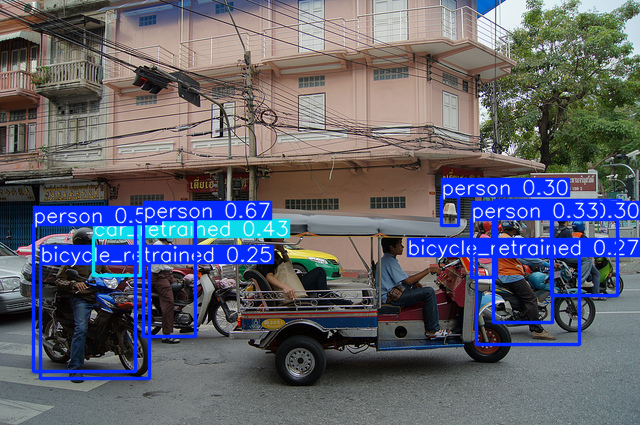

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


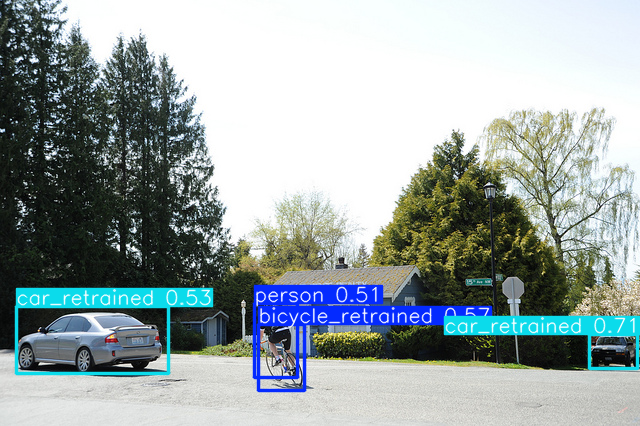

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


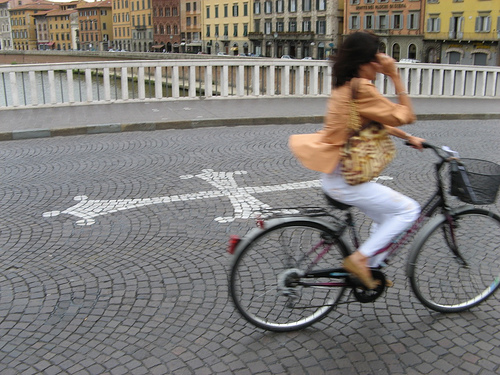

val: data=/content/yolov5/data/coco_custom.yaml, weights=['runs/train/final_model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7231279 parameters, 0 gradients, 16.5 GFLOPs
val: Scanning /content/coco/labels/train.cache... 384 images, 0 backgrounds, 0 corrupt: 100% 384/384 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 12/12 [00:10<00:00,  1.11it/s]
                   all        384       4775      0.659     0.0521     0.0566     0.0256
                person        384       1670      0.367      0.596      0.519      0.234
            m

In [1]:
# %% [markdown]
# ## YOLOv5 Custom Training com COCO - Versão Final Funcional

# %% [code] Etapa 1: Configuração do Ambiente Corrigida
# Remover instalação específica do matplotlib para evitar conflitos
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install pycocotools

# Remover diretório existente do YOLOv5
!rm -rf yolov5

# Clonar repositório atualizado
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

# %% [code] Etapa 2: Configuração do Dataset
import os
import torch
from pycocotools.coco import COCO
from PIL import Image
import requests
import glob

# Criar estrutura de diretórios
os.makedirs('/content/coco/images/train', exist_ok=True)
os.makedirs('/content/coco/labels/train', exist_ok=True)

# Download das anotações
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q -o annotations_trainval2017.zip  # Adicionado -o para sobrescrever

# Carregar COCO API
coco = COCO('annotations/instances_train2017.json')

# %% [code] Etapa 3: Processamento das Classes (Corrigido)
TARGET_CLASSES = {'bicycle': 2, 'car': 3}
MAX_IMAGES_PER_CLASS = 250

# Obter IDs válidos das classes COCO
all_coco_ids = sorted(coco.getCatIds())
coco_cats = coco.loadCats(all_coco_ids)
coco_id_to_name = {cat['id']: cat['name'] for cat in coco_cats}

# Selecionar imagens
selected_images = set()
for class_id in TARGET_CLASSES.values():
    img_ids = coco.getImgIds(catIds=class_id)[:MAX_IMAGES_PER_CLASS]
    selected_images.update(img_ids)
selected_images = list(selected_images)[:500]

# %% [code] Etapa 4: Download e Conversão das Anotações (Atualizado)
for img_id in selected_images:
    img_info = coco.loadImgs(img_id)[0]

    # Download da imagem
    img_path = f"/content/coco/images/train/{img_info['file_name']}"
    if not os.path.exists(img_path):
        try:
            img_data = requests.get(img_info['coco_url']).content
            with open(img_path, 'wb') as f:
                f.write(img_data)
        except Exception as e:
            print(f"Erro ao baixar {img_info['coco_url']}: {e}")
            continue

    # Processar anotações
    label_path = f"/content/coco/labels/train/{img_info['file_name'].replace('.jpg', '.txt')}"
    ann_ids = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(ann_ids)

    with open(label_path, 'w') as f:
        for ann in annotations:
            # Converter bbox para formato YOLO
            x, y, w, h = ann['bbox']
            img_w, img_h = img_info['width'], img_info['height']

            # Verificar bbox válido
            if w <= 0 or h <= 0:
                continue

            x_center = (x + w/2) / img_w
            y_center = (y + h/2) / img_h
            width = w / img_w
            height = h / img_h

            # Mapeamento de classes
            if ann['category_id'] in TARGET_CLASSES.values():
                class_id = 80 if ann['category_id'] == 2 else 81
            else:
                try:
                    class_id = all_coco_ids.index(ann['category_id'])
                except ValueError:
                    continue  # Ignorar classes não mapeadas

            # Escrever linha de anotação
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# %% [code] Etapa 5: Configuração do Modelo (Atualizado)
# Criar arquivo YAML corrigido
coco_names = [coco_id_to_name[cat_id] for cat_id in all_coco_ids]
custom_names = coco_names + ['bicycle_retrained', 'car_retrained']

yaml_content = f"""train: /content/coco/images/train
val: /content/coco/images/train  # Usar mesmo conjunto para validação

nc: {len(custom_names)}
names: {custom_names}
"""

with open('data/coco_custom.yaml', 'w') as f:
    f.write(yaml_content)

# %% [code] Etapa 6: Treinamento
# Separar 20% das imagens para validação
import shutil
from sklearn.model_selection import train_test_split

# Criar diretório de validação
os.makedirs('/content/coco/images/val', exist_ok=True)
os.makedirs('/content/coco/labels/val', exist_ok=True)

# Listar imagens selecionadas
all_images = [f for f in os.listdir('/content/coco/images/train') if f.endswith('.jpg')]

# Dividir treino/val (80/20)
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# Mover arquivos para val
for file in val_files:
    # Imagens
    shutil.move(
        f"/content/coco/images/train/{file}",
        f"/content/coco/images/val/{file}"
    )
    # Labels
    label_file = file.replace('.jpg', '.txt')
    shutil.move(
        f"/content/coco/labels/train/{label_file}",
        f"/content/coco/labels/val/{label_file}"
    )

!python train.py \
--img 640 \
--batch 16 \
--epochs 50 \
--data coco_custom.yaml \
--weights yolov5s.pt \
--cache \
--name final_model \
--hyp data/hyps/hyp.scratch-low.yaml \
--optimizer Adam \
--multi-scale

# %% [code] Etapa 7: Validação e Teste (Corrigido)
# Verificar se o modelo foi treinado
if os.path.exists('runs/train/final_model/weights/best.pt'):
    # Carregar modelo
    model = torch.hub.load('ultralytics/yolov5', 'custom',
                          path='runs/train/final_model/weights/best.pt',
                          force_reload=True)

    # Testar com imagens
    test_images = glob.glob('/content/coco/images/train/*.jpg')[:3]
    for img_path in test_images:
        results = model(img_path)
        results.show()

    # Métricas finais
    !python val.py \
    --data coco_custom.yaml \
    --weights runs/train/final_model/weights/best.pt \
    --img 640 \
    --task val \
    --verbose
else:
    print("Erro: Treinamento não gerou o modelo final")

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-2-4 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7231279 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


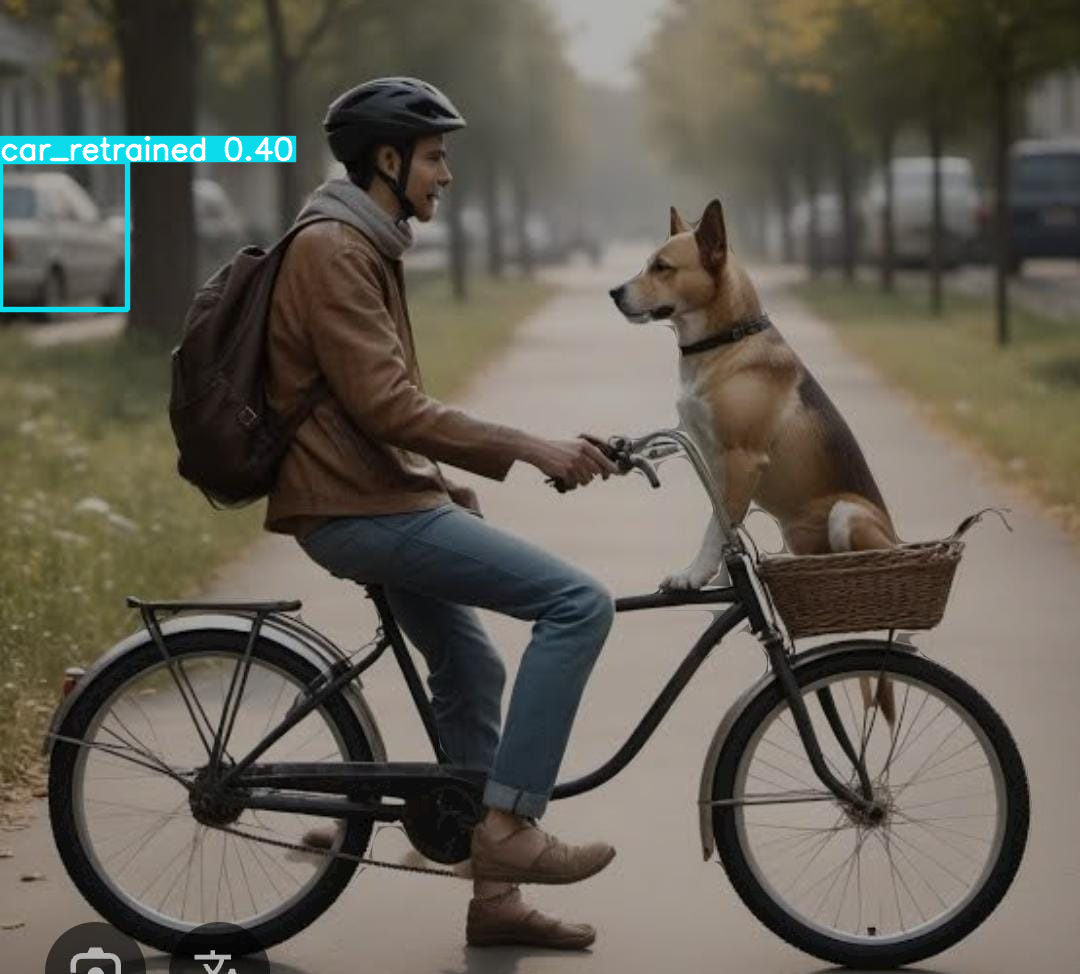

val: data=/content/yolov5/data/coco_custom.yaml, weights=['runs/train/final_model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7231279 parameters, 0 gradients, 16.5 GFLOPs
Traceback (most recent call last):
  File "/content/yolov5/val.py", line 604, in <module>
    main(opt)
  File "/content/yolov5/val.py", line 575, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/content/yolov5/val.py", line 305, in run
    data[task],
    ~~~~^^^^^^
KeyE

In [2]:
# Verificar se o modelo foi treinado
if os.path.exists('runs/train/final_model/weights/best.pt'):
    # Carregar modelo
    model = torch.hub.load('ultralytics/yolov5', 'custom',
                          path='runs/train/final_model/weights/best.pt',
                          force_reload=True)

    # Testar com imagens
    test_images = glob.glob('/content/coco/images/test/WhatsApp Image 2025-02-04 at 13.21.53.jpeg')
    for img_path in test_images:
        results = model(img_path)
        results.show()

    # Métricas finais
    !python val.py \
    --data coco_custom.yaml \
    --weights runs/train/final_model/weights/best.pt \
    --img 640 \
    --task test \
    --verbose
else:
    print("Erro: Treinamento não gerou o modelo final")